In [110]:
import seastar as ss
import xarray as xr
import numpy as np
import pdb

In [112]:
along_length = 2
across_length = 2
level1 = xr.Dataset(
    data_vars=dict(
            CentralWavenumber=( [],270 ),
            CentralFreq=( [], 13.5 * 10**9 ),
            IncidenceAngleImage=(['along','across','Antenna'],
                     np.stack((np.full([along_length, across_length], 36.5),
                              np.full([along_length, across_length], 28.4),
                              np.full([along_length, across_length], 36.5)
                              ),axis=-1
                             )
                    ),
            AntennaAzimuthImage=(['along','across', 'Antenna'],
                           np.stack((np.full([along_length, across_length], 45),
                                     np.full([along_length, across_length], 90),
                                     np.full([along_length, across_length], 135)
                                     ), axis=-1)
                                ),
            Polarization=(['along','across','Antenna'],
                          np.stack((np.full([along_length, across_length], 'VV'),
                                    np.full([along_length, across_length], 'VV'),
                                    np.full([along_length, across_length], 'VV')
                                    ), axis=-1)
                         ),
    ),
    coords=dict(
            along=np.arange(0,along_length),
            across=np.arange(0,across_length),
            Antenna=['Fore','MidV','Aft'],
        ),
)
level1 = level1.set_coords([
    'CentralWavenumber','CentralFreq','IncidenceAngleImage','AntennaAzimuthImage','Polarization', 
])
geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(['along','across'], np.full([along_length, across_length], 5.)), #5m/s
            WindDirection=(['along','across'], np.full([along_length, across_length], 0.)), #0 degrees
            CurrentVelocity=(['along','across'], np.full([along_length, across_length], 0.6)), #0.6m/s
            CurrentDirection=(['along','across'], np.full([along_length, across_length], 150.)), 
        ),
        coords=dict(
            along=np.arange(0, along_length),
            across=np.arange(0,across_length),
        ),
    )
geo['EarthRelativeWindSpeed'] = geo.WindSpeed
geo['EarthRelativeWindDirection'] = geo.WindDirection
ss.utils.tools.EarthRelativeSpeedDir2all(geo)
geo['WindSpeed'] = geo.OceanSurfaceWindSpeed
geo['WindDirection'] = geo.OceanSurfaceWindDirection

gmf = {'doppler':{'name':'yurovsky19'}, 'nrcs':{'name':'nscat4ds'}}
level1['Sigma0'] = ss.gmfs.nrcs.compute_nrcs(level1, geo, gmf['nrcs'])

model_rsv_list = [None] * level1.Antenna.size
model_wasv_list = [None] * level1.Antenna.size
for aa, ant in enumerate(level1.Antenna.data):
    model_rsv_list[aa] = ss.gmfs.doppler.compute_total_surface_motion(level1.sel(Antenna=ant),
                                                                      geo,
                                                                      gmf=gmf['doppler']['name'])
level1['RSV'] = xr.concat(model_rsv_list, dim='Antenna')

level1['RSV'].loc[dict(Antenna='Fore')][1,1] = 100
#level1['Sigma0'].loc[dict(Antenna='Fore')][2,2] = ss.utils.tools.db2lin(200)

In [113]:
noise_RSV = 0.05
baseline_sigma0_noise = 0.03
baseline_mid_RSV_noise = 0.8
uncertainty = xr.Dataset(
        data_vars=dict(
            RSV=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], noise_RSV),
                                  np.full([along_length, across_length], baseline_mid_RSV_noise),
                                  np.full([along_length, across_length], noise_RSV)
                                  ),axis=-1
                                 )
                        ),
            Kp=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], baseline_sigma0_noise),
                                  np.full([along_length, across_length], baseline_sigma0_noise),
                                  np.full([along_length, across_length], baseline_sigma0_noise)
                                  ),axis=-1
                                 )
                        ),
        ),
        coords=dict(
                along=np.arange(0,along_length),
                across=np.arange(0,across_length),
                Antenna=['Fore','MidV','Aft'],
            ),
    )
uncertainty, noise = ss.performance.scene_generation.uncertainty_fct(level1, uncertainty)
level1n = ss.performance.scene_generation.noise_generation(level1, noise)

To Be Done - uncertainty function


In [115]:
#pdb.set_trace()
lmout = ss.retrieval.level2.run_find_minima(level1n, noise, gmf, serial=False)

In [99]:
# success mask
bounds = lmout.bounds.isel(extrema=0, along=0, across=0).data
x_limit = [np.sqrt(bounds **2 + bounds **2)[i] for i in [0,2]]
mask = xr.where(lmout.success.sum(dim='Ambiguities') == len(lmout.Ambiguities), True, False)
#    and xr.where(np.abs(L2.CurrentVelocity - x_limit[1]) < 0.01, False, True)\
#    and xr.where(np.abs(L2.WindSpeed - x_limit[0]) < 0.01, False, True)

mask

<xarray.DataArray 'success' (along: 4, across: 4)>
array([[ True,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])
Coordinates:
  * along              (along) int32 0 1 2 3
  * across             (across) int32 0 1 2 3
    CentralFreq        float64 1.35e+10
    CentralWavenumber  int32 270

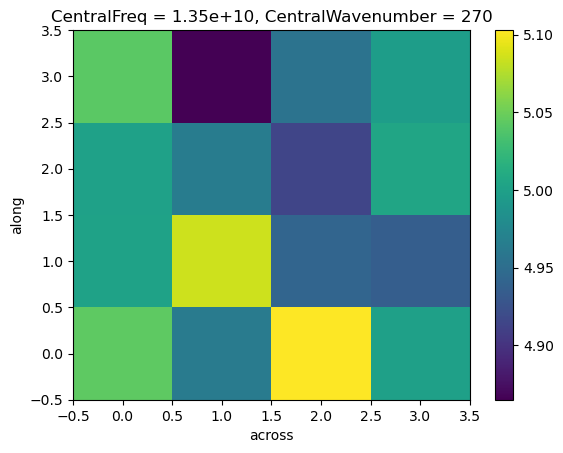

In [104]:
ambiguity = {'name':'sort_by_cost'}
#ambiguity = {'name':'closest_truth','truth':geo,'method':'wind'}
sol = ss.retrieval.ambiguity_removal.solve_ambiguity(lmout, ambiguity)
L2 = ss.retrieval.level2.sol2level2(sol)
mask = xr.where(lmout.success.sum(dim='Ambiguities') == len(lmout.Ambiguities), True, False)
xr.where(mask, L2.WindSpeed, np.nan).plot()